In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras as keras
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


# Define Functions

In [2]:
def read_data(file):
    """
    Read csv data from the specified file location.
    """
    df = pd.read_csv(file, index_col='Date')
    return df

In [3]:
def clip_recent_days(df, n_days):
    """
    optional
    remove recent days from data frame
    """
    return(df[:-n_days])

In [4]:
def format_predictors_and_targets(df):
    
    df = df.dropna()
    
    predictors = df[['back_5', 'back_4', 'back_3', 'back_2', 'back_1']].values
    assert type(predictors) is np.ndarray
    
    n_cols = predictors.shape[1]
    
    targets = df[['Adj Close']].values
    assert type(targets) is np.ndarray
    
    return predictors, targets, n_cols

# Prepare Data

In [5]:
# DEFINE DATA CONSTANTS
TEST_SIZE = 0.05

In [6]:
# specify location of time series data
file_path = '../data/interim/time_series.csv'

In [7]:
# read time series data
time_series_df = read_data(file_path)
time_series_df

,back_5,back_4,back_3,back_2,back_1,Adj Close
Date,,,,,,
1962-01-02,NaN,NaN,NaN,NaN,NaN,0.014743
1962-01-03,NaN,NaN,NaN,NaN,0.014743,0.002435
1962-01-04,NaN,NaN,NaN,0.014743,0.002435,-0.022141
1962-01-05,NaN,NaN,0.014743,0.002435,-0.022141,-0.002490
1962-01-08,NaN,0.014743,0.002435,-0.022141,-0.002490,-0.002498
...,...,...,...,...,...,...
2020-04-03,0.014775,0.012455,-0.011656,0.073689,-0.029898,0.031629
2020-04-06,0.012455,-0.011656,0.073689,-0.029898,0.031629,0.018848
2020-04-07,-0.011656,0.073689,-0.029898,0.031629,0.018848,0.061366


In [8]:
time_series_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14669 entries, 1962-01-02 to 2020-04-09
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   back_5     14664 non-null  float64
 1   back_4     14665 non-null  float64
 2   back_3     14666 non-null  float64
 3   back_2     14667 non-null  float64
 4   back_1     14668 non-null  float64
 5   Adj Close  14668 non-null  float64
dtypes: float64(6)
memory usage: 802.2+ KB


In [9]:
# call function to format predictors and targets
#tomorrow = time_series_df.iloc[[-1]].fillna(0)
#tomorrow, _ , _ = format_predictors_and_targets(tomorrow)
predictors, targets, n_cols = format_predictors_and_targets(time_series_df)

In [10]:
# scale data to range [0,1]
X_scaler = MinMaxScaler(feature_range=(0,1))
y_scaler = MinMaxScaler(feature_range=(0,1))

predictors = X_scaler.fit_transform(predictors)
#tomorrow = X_scaler.transform(tomorrow)
targets = y_scaler.fit_transform(targets)

In [11]:
# test for correct scaling
assert min(predictors.flatten()) == 0
assert max(predictors.flatten()) == 1
assert min(targets.flatten()) == 0
assert max(targets.flatten()) == 1

**Important for Time Series Analysis:**

The training set must only contain stock price data for dates prior to all of the test data.

The model will be overly optimistic if it trained on future data and evaluated on previous data.


RESULT: Random split will not work
split needs to be sequential.


[____________ALL_____SEQUENTIAL_______DATA______]


[____________TRAINING    DATA_____],[___________TEST_DATA____]

In [12]:
# split data into training set and testing set
# SHUFFLE = FALSE
X_train, X_test, y_train, y_test = train_test_split(predictors, targets, test_size=TEST_SIZE, shuffle=False, stratify=None, random_state=1)

In [13]:
# test for sequential split
assert np.argwhere(predictors == X_train[-1])[0][0] == (np.argwhere(predictors == X_test[0])[0][0]) -1
assert np.argwhere(predictors == y_train[-1])[0][0] == (np.argwhere(predictors == y_test[0])[0][0]) -1

In [14]:
# how many days of stock data are in the test set?
len(y_test)

734

# Build Model

In [15]:
#tomorrow = np.reshape(tomorrow, (tomorrow.shape[0], 1, tomorrow.shape[1]))
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

X_train.shape#, tomorrow.shape

(13929, 1, 5)

In [16]:
#y_train = np.reshape(y_train, (y_train.shape[0], 1, y_train.shape[1]))
#y_test = np.reshape(y_test, (y_test.shape[0], 1, y_test.shape[1]))

In [17]:
def build_sequential_LSTM(n_nodes, n_layers, add_dense):
    
    model = Sequential()
    
    model.add(LSTM(n_nodes, return_sequences=True, input_shape=X_train.shape[1:]))
    

    # add LSTM layers that also use nodes from the same layer
    for i in range(n_layers-2):
        model.add(LSTM(n_nodes, return_sequences=True))
    
    #return_sequences = False if next layer is not LSTM
    model.add(LSTM(n_nodes, return_sequences=False))
    
    
    if add_dense:
        # add Fully Connected Layer
        model.add(Dense(n_nodes, activation='relu'))
        
    model.add(Dense(1))
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model

In [18]:
# DEFINE MODEL CONSTANTS
N_NODES = 100
N_LAYERS = 4
ADD_DENSE = True

In [19]:
# build Sequential Model
model = build_sequential_LSTM(N_NODES, N_LAYERS, ADD_DENSE)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 100)            42400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 100)            80400     
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 100)            80400     
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 293,801
Trainable params: 293,801
Non-trainable params: 0
________________________________________________

# Fit The Model

In [20]:
# DEFINE TRAINING CONSTANTS
EPOCHS = 1

In [21]:
model.fit(X_train, y_train, epochs=EPOCHS)

Epoch 1/1
13929/13929 [==============================] - 12s 893us/step - loss: 0.0142


# Save The Model

In [22]:
# save and load model
model.save('../models/keras_lstm.h5')
model = load_model('../models/keras_lstm.h5')

# verify model structure
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 100)            42400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 100)            80400     
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 100)            80400     
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 293,801
Trainable params: 293,801
Non-trainable params: 0
________________________________________________

# Make predictions and interpret results

In [23]:
# Make Predictions
predictions = model.predict(X_test)
#tomorrows_prediction = model.predict(tomorrow)
#tomorrows_prediction

In [24]:
# inspect range of scaled predictions
print("Original Prediction Range:\t", min(predictions), max(predictions))
print("Expected Range:\t\t\t", min(y_test), max(y_test))

Original Prediction Range:	 [0.59022635] [0.6416572]
Expected Range:			 [0.31631961] [0.89503638]


In [25]:
# revert scaling
#tomorrow_unscaled = y_scaler.inverse_transform(tomorrows_prediction)
unscaled_predictions = y_scaler.inverse_transform(predictions)
unscaled_y_test = y_scaler.inverse_transform(y_test)
print("Unscaled Prediction Range:\t", min(unscaled_predictions), max(unscaled_predictions))
print("Expected Range:\t\t\t", min(unscaled_y_test), max(unscaled_y_test))

Unscaled Prediction Range:	 [-0.01214495] [0.01005783]
Expected Range:			 [-0.13039097] [0.11944208]


In [26]:
# apply exponential function
#exponential_tomorrow = np.exp(tomorrow_unscaled)
exponential_predictions = np.exp(unscaled_predictions)
exponential_y_test = np.exp(unscaled_y_test)
print("Exponential Prediction Range:\t", min(exponential_predictions), max(exponential_predictions))
print("Exponential Prediction Range:\t", min(exponential_y_test), max(exponential_y_test))

Exponential Prediction Range:	 [0.9879285] [1.0101086]
Exponential Prediction Range:	 [0.87775219] [1.12686797]


In [27]:
# Inspect quality of predictions
places = 4
min_pred = round(float(min(exponential_predictions)), places)
max_pred = round(float(max(exponential_predictions)), places)
mean_pred = round(float(np.mean(exponential_predictions)), places)
median_pred = round(float(np.median(exponential_predictions)), places)
percentile = round(np.percentile(exponential_predictions, 1.0), places)*100
print("min pred:\t", min_pred)
print("max pred:\t", max_pred)
print("mean pred:\t", mean_pred)
print("median pred:\t", median_pred)
print("percentile(1.0):", percentile)


is_good_model = min_pred<=1.0 and max_pred>=1.0
assert is_good_model

min pred:	 0.9879
max pred:	 1.0101
mean pred:	 1.0019
median pred:	 1.0021
percentile(1.0): 99.4


# Score Model

In [28]:
def get_accuracy(y, pred):
    
    #scale and shift binary results
    # -1 -> stock went down
    # +1 -> stock increased or stayed the same
    y = ((y>=1)*2)-1
    pred = ((pred>=1)*2)-1
    
    # stocks move in the same direction when a_i*b_i is positive
    accuracy = (np.sum((y*pred)>=0)/len(y))*100
    
    print("Predicting change in stock price with %f%s accuracy" % (accuracy,'%'))
    
    return accuracy

In [29]:
accuracy = get_accuracy(exponential_y_test, exponential_predictions)

Predicting change in stock price with 50.000000% accuracy


# Visualize Predictions

In [30]:
# read data with Adj Close Price
raw_data = pd.read_csv('../data/raw/raw.csv', index_col=['Date'])
raw_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1962-01-02,0.000000,1.589844,1.578125,1.578125,0.013913,902400
1962-01-03,0.000000,1.601562,1.578125,1.601562,0.014120,1200000
1962-01-04,0.000000,1.613281,1.597656,1.605469,0.014154,1088000
1962-01-05,0.000000,1.613281,1.566406,1.570312,0.013844,1222400
1962-01-08,0.000000,1.582031,1.546875,1.566406,0.013810,1388800
...,...,...,...,...,...,...
2020-04-03,41.450001,42.180000,38.520000,39.209999,39.209999,48425700
2020-04-06,39.880001,40.830002,39.230000,40.470001,40.470001,41301900
2020-04-07,42.900002,43.320000,41.160000,41.240002,41.240002,48921800


In [31]:
# Create DataFrame to Hold vizualization data
viz_df = raw_data[['Adj Close']]
viz_df.columns = ['price']
viz_df


viz_df = viz_df.dropna()
viz_df = viz_df.iloc[len(X_train)+5:-1]


predictions_df = pd.DataFrame(exponential_predictions)
predictions_df['actual_return'] = exponential_y_test
predictions_df.index = viz_df.index
predictions_df.columns = ['exp_preds', 'actual_return']
predictions_df

viz_df['exponential_prediction'] = predictions_df.exp_preds
viz_df['actual_return'] = predictions_df.actual_return

viz_df['predicted_price'] = viz_df.price * viz_df.exponential_prediction

viz_df['expected_change'] = viz_df.predicted_price - viz_df.price
viz_df['correct_prediction'] = ((viz_df.exponential_prediction>=1.0) * (viz_df.actual_return>=1.0)) + ((viz_df.exponential_prediction<1.0) * (viz_df.actual_return<1.0))
viz_df['color'] = viz_df.correct_prediction.map({True:'green', False:'red'})
viz_df

/home/alhalarewicz/anaconda3/envs/TimeSeries/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/alhalarewicz/anaconda3/envs/TimeSeries/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "


,price,exponential_prediction,actual_return,predicted_price,expected_change,correct_prediction,color
Date,,,,,,,
2017-05-10,72.611153,1.002148,1.008546,72.767115,0.155962,True,green
2017-05-11,73.231689,1.003027,0.999274,73.453376,0.221687,False,red
2017-05-12,73.178505,1.002654,1.003028,73.372709,0.194204,True,green
2017-05-15,73.400116,1.002494,0.996981,73.583200,0.183084,False,red
2017-05-16,73.178505,1.002627,0.993216,73.370711,0.192206,False,red
...,...,...,...,...,...,...,...
2020-04-02,40.400002,1.004201,0.970544,40.569705,0.169703,False,red
2020-04-03,39.209999,1.004590,1.032135,39.389956,0.179957,True,green
2020-04-06,40.470001,1.005577,1.019026,40.695716,0.225714,True,green


In [32]:
viz_df1 = viz_df.loc['2019-01-01':'2019-01-31']


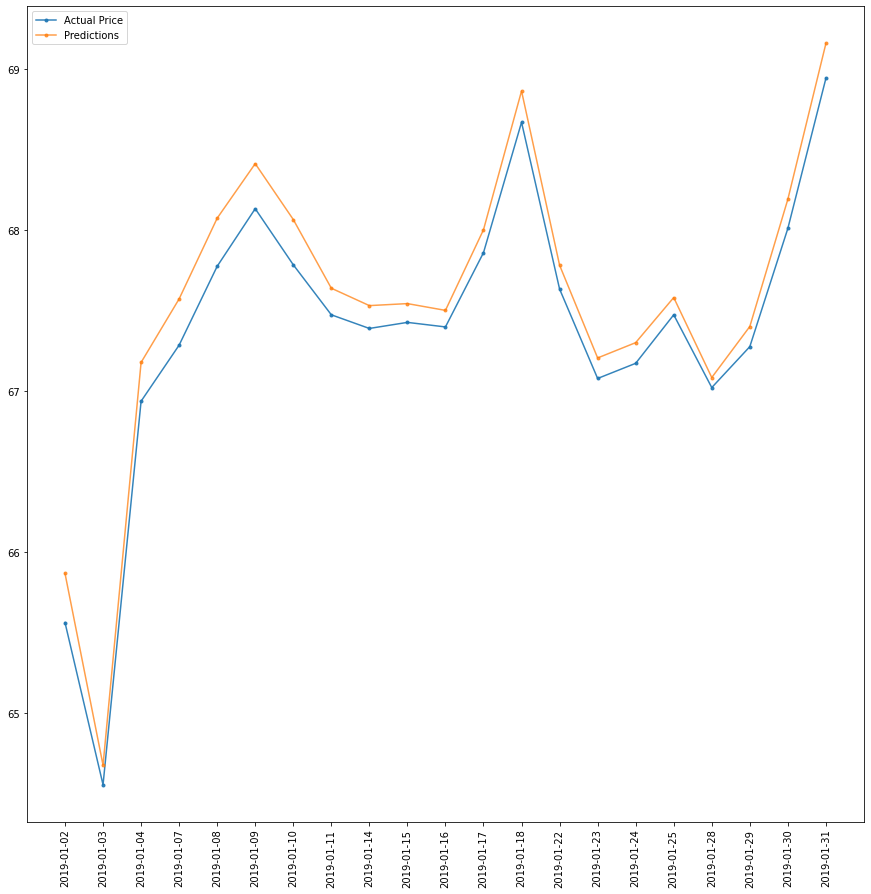

In [33]:
_ = plt.figure(figsize=(15,15))
_ = plt.plot(viz_df1['price'], marker='.', alpha=0.9)
_ = plt.plot(viz_df1['predicted_price'], marker='.', alpha=0.75)
_ = plt.legend(['Actual Price', 'Predictions'])
_ = plt.xticks(rotation=90)
plt.show()

In [34]:
xi = list(viz_df1.index)
yi = [pt for pt in viz_df1['price']]
yf = [pt for pt in viz_df1['predicted_price']]
delta = list(viz_df1.expected_change)
color = list(viz_df1.color)
#for pt in viz_df1['price']:
    #yi.append(pt)
#for pt in viz_df1['predicted_price']:
    #yf.append(pt)

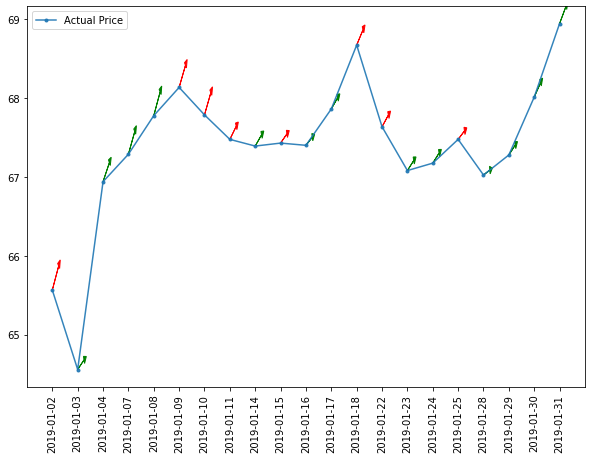

In [35]:
_ = plt.figure(figsize=(10,7))
_ = plt.plot(viz_df1['price'], marker='.', alpha=0.9)
#_ = plt.plot(viz_df1['predicted_price'], marker='.', alpha=0.75, linestyle='None')
_ = plt.legend(['Actual Price', 'Predictions'])
_ = plt.xticks(rotation=90)

#_ = plt.arrow(xi[0], yi[0],0, delta[0], head_width=0.1, head_length=0.1, color=color[0])
for i in range(len(xi)):
    _ = plt.arrow(xi[i], yi[i],0.25, delta[i], head_width=0.1, head_length=0.1, color=color[i])
plt.show()

# Tomorrow's prediction

In [36]:
expected_return = float(exponential_tomorrow)
tomorrow_df['price_today'] = raw_data[['Adj Close']].iloc[[-1]]
tomorrow_df['price_tomorrow'] = tomorrow_df['price_today']* expected_return
tomorrow_df

NameError: name 'exponential_tomorrow' is not defined